In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import (
    ToTensor,
    RandomHorizontalFlip,
    Compose,
    RandomResizedCrop,
    Resize,
)
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from torch.utils.data import random_split
import copy

# Loading the dataset
- CIFAR10, 100전용 padding 4 pixel 및 random 32*32 crop하는 데이터 전처리
- Randomhorizontal filp : p = 0.5
- Subtract mean per each pixel

In [2]:
class Submean(torch.nn.Module):
    def __init__(self):
        super().__init__()
        return None

    def __call__(self, tensor):
        # Subtract the mean from each pixel along each channel
        _mean = tensor.mean(axis=(1, 2))
        tensor = tensor - _mean[:, None, None]

        return tensor


class CustomRandomResizedCrop(RandomResizedCrop):
    def __call__(self, img):
        
        # Add padding to the image
        img = F.pad(img, (4, 4, 4, 4), mode="constant", value=0)
        return super().__call__(img)


class LoadDataset:
    def __init__(self, root, seceted_dataset="CIFAR100"):
        self.Randp = 0.5
        CROPSIZE = 32
        self.CropSize = [CROPSIZE, CROPSIZE]
        self.dataset_name = seceted_dataset
        dataset_mapping = {
            "CIFAR100": datasets.CIFAR100,
            "CIFAR10": datasets.CIFAR10,
            # Add more datasets if needed
        }

        default_transforms = Compose([
            ToTensor(), 
            # Resize((224, 224)),
            Submean()])

        if self.dataset_name in dataset_mapping:
            ref_train = dataset_mapping[self.dataset_name](
                root=root,
                train=True,
                download=True,
                transform=default_transforms,
            )
            self.testing_data = dataset_mapping[self.dataset_name](
                root=root,
                train=False,
                download=True,
                transform=default_transforms,
            )
        else:
            raise ValueError(f"Unsupported dataset: {self.dataset_name}")

        # Split to train and valid set
        total_length = len(ref_train)
        train_length = int(total_length * 0.9)
        valid_length = total_length - train_length
        splited_train, self.valid_data = random_split(
            ref_train, [train_length, valid_length]
        )

        # Apply transform at each dataset
        self.train_data = splited_train
        self.train_data.transform = copy.deepcopy(default_transforms)
        ### 여기 transforms도 주소 레퍼런스따는거라 deep copy한 다음에 append해야함.
        self.train_data.transform.transforms.append(RandomHorizontalFlip(self.Randp))
        self.train_data.transform.transforms.append(
            CustomRandomResizedCrop(self.CropSize)
        )
        self.valid_data.transform = default_transforms
        """
        random crop : https://arxiv.org/pdf/1409.5185.pdf
        we also augmented the dataset by zero padding 4 pixels on each side, then do corner cropping and random flipping on
        the fly during training. No model averaging is done at the test phase and we only crop the center of a test sample

        """

        # Copy classes data
        self.train_data.classes = ref_train.classes
        self.valid_data.classes = ref_train.classes

        self.train_data.class_to_idx = ref_train.class_to_idx
        self.valid_data.class_to_idx = ref_train.class_to_idx

        return

    def unpack(self):
        print("-----------------------------------------------------------------------")
        print("Dataset : ", self.dataset_name)
        print("- Length of Train Set : ", len(self.train_data))
        print("- Length of Valid Set : ", len(self.valid_data))
        print("- Length of Test Set : ", len(self.testing_data))
        print("- Count of Classes : ", len(self.train_data.classes))

        return (
            self.train_data,
            self.valid_data,
            self.testing_data,
            len(self.train_data.classes),
        )

## Confirm that the dataset is loaded properly

In [3]:
BATCH = 256
DATASET = "CIFAR10"

In [4]:
_dataset = LoadDataset(root="data", seceted_dataset=DATASET)
train_data, valid_data, test_data, COUNT_OF_CLASSES = _dataset.unpack()

train_dataloader = DataLoader(train_data, batch_size=BATCH, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10


In [5]:
print(train_data.transform)
print(valid_data.transform)
print(test_data.transform)

Compose(
    ToTensor()
    Submean()
    RandomHorizontalFlip(p=0.5)
    CustomRandomResizedCrop(size=[32, 32], scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
)
Compose(
    ToTensor()
    Submean()
)
Compose(
    ToTensor()
    Submean()
)


### Testset info

In [6]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print("mean of X", X.mean(dim=(0, 2, 3)))
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([-1.2828e-09, -1.4270e-09, -9.3061e-10])
Shape of y: torch.Size([256]) torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

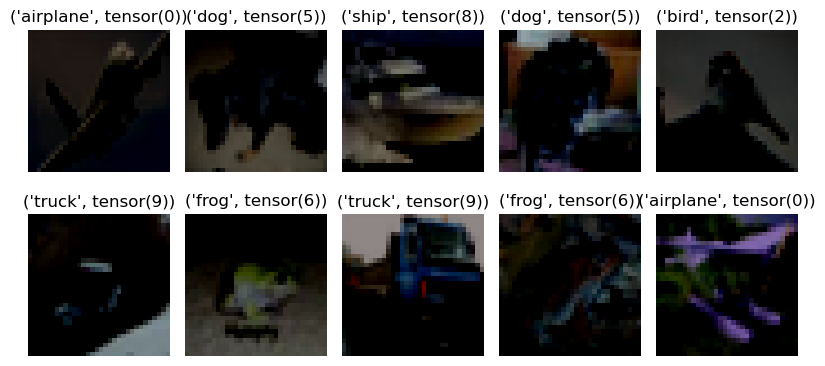

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Get the class names
class_names = test_dataloader.dataset.classes
count = 0

# Create a subplot with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(8, 4))

# Iterate over the first batch of images and labels
for images, labels in test_dataloader:
    # Convert the images to numpy arrays
    images = images.numpy()
    
    # Iterate over the images and labels
    for i in range(len(images)):
        # Get the image and label
        image = images[i]
        label = labels[i]
        
        # Convert the image from tensor to numpy array
        image = np.transpose(image, (1, 2, 0))
        
        # Plot the image in the appropriate subplot
        ax = axs[count // 5, count % 5]
        ax.imshow(image)
        ax.set_title(f"{class_names[label], label}")
        ax.axis('off')
        
        # Increment the count
        count += 1
        
        # Break the loop if we have displayed 10 images
        if count == 10:
            break
            
    # Break the loop if we have displayed 10 images
    if count == 10:
        break

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Imaplemant The Model

In [8]:
class Block(nn.Module):
    def __init__(self, inputs, outputs, _Downsample=False):
        super().__init__()
        self._Downsample = _Downsample

        self.relu = nn.ReLU(inplace=False)

        self.conv1 = nn.Conv2d(inputs, outputs, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1)

        self.conv2 = nn.Conv2d(outputs, outputs, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1)

        if self._Downsample == True:
            self.conv1.stride = 2

            self.conv_down = nn.Conv2d(
                inputs, outputs, kernel_size=1, stride=2, bias=False
            )
            # In paper, downsampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
            # 이거 토치 공식 resnet에서도 배치까지 있는 4차원이라 conv2d로 함.
            # 여기 BN빼니까 완전히 망가져버림. acc 10% 찍힘.
            nn.init.kaiming_normal_(
                self.conv_down.weight, mode="fan_out", nonlinearity="relu"
            )
            self.bn_down = nn.BatchNorm2d(
                outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            )

        """
        https://pytorch.org/docs/stable/_modules/torch/nn/init.html#kaiming_normal_
        """
        nn.init.kaiming_normal_(self.conv1.weight, mode="fan_out", nonlinearity="relu")
        nn.init.kaiming_normal_(self.conv2.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, x):
        # print("x1(identity) :", x.shape, "Downsample :", self._Downsample)
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # print("x2 :", x.shape)
        x = self.conv2(x)
        x = self.bn2(x)

        if self._Downsample == True:
            identity = self.conv_down(identity)
            identity = self.bn_down(identity)
            # print("x3(downsampled) :", identity.shape)
        # print("x4 :", identity.shape)
        x = x + identity  # 여기 x+=identity로 하면 안 됨. inplace operation이라서.
        x = self.relu(x)
        return x


class MyResNet34(nn.Module):
    def __init__(self, _BlockClass=Block, _num_classes=1000):
        super().__init__()
        self._num_classes = _num_classes

        # 1. input layer
        # input : 224x224x3        # output : 112x112x64
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )

        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 2. 64ch 3x3 conv x 3
        # input : 112x112x64        # output : 56x56x64
        self.conv64blocks = nn.Sequential(
            _BlockClass(64, 64), _BlockClass(64, 64), _BlockClass(64, 64)
        )

        # 3. 128ch 3x3 conv x 4
        # input : 56x56x64        # output : 28x28x128
        self.conv128blocks = nn.Sequential(
            _BlockClass(64, 128, _Downsample=True),
            _BlockClass(128, 128),
            _BlockClass(128, 128),
            _BlockClass(128, 128),
        )

        # 4. 256ch 3x3 conv x 6
        # input : 28x28x128        # output : 14x14x256
        self.conv256blocks = nn.Sequential(
            _BlockClass(128, 256, _Downsample=True),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
        )

        # 5. 512ch 3x3 conv x 3
        # input : 14x14x256        # output : 7x7x512
        self.conv512blocks = nn.Sequential(
            _BlockClass(256, 512, _Downsample=True),
            _BlockClass(512, 512),
            _BlockClass(512, 512),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(
            in_features=512, out_features=self._num_classes, bias=True
        )

        nn.init.kaiming_normal_(self.conv1.weight, mode="fan_out", nonlinearity="relu")
        nn.init.kaiming_normal_(self.fc1.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.conv64blocks(x)
        # print(x.shape)
        x = self.conv128blocks(x)
        # print(x.shape)
        x = self.conv256blocks(x)
        # print(x.shape)
        x = self.conv512blocks(x)
        # print(x.shape)
        x = self.avgpool(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)

        return x

# Define the model

In [9]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [10]:
model = MyResNet34(Block, COUNT_OF_CLASSES).to(device)
# model.named_modules

In [18]:
from fvcore.nn import FlopCountAnalysis
from fvcore.nn import flop_count_table

tmp_input = torch.rand(1, 3, 224, 224).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                       | #parameters or shape   | #flops     |
|:-----------------------------|:-----------------------|:-----------|
| model                        | 21.29M                 | 3.671G     |
|  conv1                       |  9.408K                |  0.118G    |
|   conv1.weight               |   (64, 3, 7, 7)        |            |
|  bn1                         |  0.128K                |  1.606M    |
|   bn1.weight                 |   (64,)                |            |
|   bn1.bias                   |   (64,)                |            |
|  conv64blocks                |  0.222M                |  0.696G    |
|   conv64blocks.0             |   73.984K              |   0.232G   |
|    conv64blocks.0.conv1      |    36.864K             |    0.116G  |
|    conv64blocks.0.bn1        |    0.128K              |    0.401M  |
|    conv64blocks.0.conv2      |    36.864K             |    0.116G  |
|    conv64blocks.0.bn2        |    0.128K              |    0.401M  |
|   co

In [12]:
# How many have params?
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of total parameters: {total_params/1e6:2.2f}M")

Number of total parameters: 21.29M


# Training loop

In [13]:
NUM_EPOCHS = 5000
single_iter_time = 11

print(f"almost {single_iter_time * NUM_EPOCHS * 1.1 / 3600:.2f} hours")

almost 16.81 hours


In [14]:
MIN_LR = 0.0001
# 0.1, 0.01, 0.001까지 학습시켰으니, 0.0001에선 종료

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=500,
    factor=0.1,
    verbose=True,
    threshold=1e-5,
    min_lr=MIN_LR,
)
"""
ReduceLROnPlateau 스케줄러는 mode='min'으로 설정되어 손실이 감소해야 학습률을 조절합니다. 
patience는 얼마나 기다렸다가 학습률을 조절할지를 결정하며, 
factor는 학습률을 조절할 때 사용할 인수입니다. 
>> now learning의 0.1로 조정 >> divide by 10
verbose=True로 설정하면 언제 학습률이 조절되었는지 출력됩니다.

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
"""
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

"\nReduceLROnPlateau 스케줄러는 mode='min'으로 설정되어 손실이 감소해야 학습률을 조절합니다. \npatience는 얼마나 기다렸다가 학습률을 조절할지를 결정하며, \nfactor는 학습률을 조절할 때 사용할 인수입니다. \n>> now learning의 0.1로 조정 >> divide by 10\nverbose=True로 설정하면 언제 학습률이 조절되었는지 출력됩니다.\n\nhttps://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html\n"

In [15]:
_log_train_loss = []
_log_train_acc = []
_log_valid_loss = []
_log_valid_acc = []
_log_test_loss = []
_log_test_acc = []

for epoch in range(NUM_EPOCHS):
    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] :")
    start_time = time.time()

    # Training loop @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Training time: {execution_time:.2f} seconds")

    # Evaluation loop @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    valid_loss /= len(valid_dataloader)
    valid_acc = correct / total

    scheduler.step(valid_loss)

    # Testing loop @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_dataloader)
    test_acc = correct / total

    # Print epoch statistics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc*100:.2f}%")
    print(f"Test  Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

    _log_train_loss.append(train_loss)
    _log_train_acc.append(train_acc)
    _log_valid_loss.append(valid_loss)
    _log_valid_acc.append(valid_acc)
    _log_test_loss.append(test_loss)
    _log_test_acc.append(test_acc)

    # Early stopping
    current_lr = optimizer.param_groups[0]["lr"]
    # print(f" Current Learning Rate: {current_lr}")
    if current_lr == MIN_LR:
        print("break!")
        break
    print("-" * 50)

[Epoch 1/5000] :


Training time: 10.13 seconds
Train Loss: 4.7783 | Train Acc: 10.06%
Valid Loss: 2.3741 | Valid Acc: 10.26%
Test  Loss: 2.3997 | Test Acc: 10.24%
--------------------------------------------------
[Epoch 2/5000] :
Training time: 10.02 seconds
Train Loss: 2.4119 | Train Acc: 14.84%
Valid Loss: 2.2960 | Valid Acc: 15.60%
Test  Loss: 2.3178 | Test Acc: 16.23%
--------------------------------------------------
[Epoch 3/5000] :
Training time: 10.04 seconds
Train Loss: 2.1187 | Train Acc: 21.74%
Valid Loss: 1.9684 | Valid Acc: 25.40%
Test  Loss: 1.9772 | Test Acc: 25.92%
--------------------------------------------------
[Epoch 4/5000] :
Training time: 10.03 seconds
Train Loss: 1.9330 | Train Acc: 27.92%
Valid Loss: 1.9146 | Valid Acc: 27.96%
Test  Loss: 1.9408 | Test Acc: 28.71%
--------------------------------------------------
[Epoch 5/5000] :
Training time: 10.06 seconds
Train Loss: 1.8310 | Train Acc: 31.32%
Valid Loss: 1.8091 | Valid Acc: 32.14%
Test  Loss: 1.8160 | Test Acc: 32.75%
---

KeyboardInterrupt: 

# Results

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# 첫 번째 그래프: Training and Test Loss
axs[0].plot(_log_train_loss, label="Training Loss")
axs[0].plot(_log_valid_loss, label="Validation Loss")
axs[0].plot(_log_test_loss, label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training, Validation and Test Loss")
axs[0].legend()

# 두 번째 그래프: Training and Test Accuracy
axs[1].plot(_log_train_acc * 100, label="Training Accuracy")
axs[1].plot(_log_valid_acc * 100, label="Validation Accuracy")
axs[1].plot(_log_test_acc * 100, label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training, Validation and Test Accuracy")
axs[1].legend()

# 그래프를 보여줍니다.
plt.tight_layout()
plt.show()
_log_test_acc[-1] * 100

In [ ]:
# torch.save(model.state_dict(), "models/Myresnet34.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
model = MyResNet34(Block, COUNT_OF_CLASSES).to(device)
model.load_state_dict(torch.load("models/Myresnet34.pth"))

In [ ]:
model.named_modules

In [ ]:
# Testing loop
model.eval()
test_loss = 0.0
correct = 0
total = 0
start_time = time.time()

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        break

test_loss /= len(test_dataloader)
test_acc = correct / total
end_time = time.time()
execution_time = end_time - start_time
print(f"Training time: {execution_time:.2f} seconds")
print(total)